In [36]:
from io import open
import glob
import os

In [37]:
def findFiles(path): return glob.glob(path)

In [38]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [39]:
import unicodedata
import string

In [40]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [41]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )

In [42]:
category_lines = {}
all_categories = []

In [43]:
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [44]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [45]:
n_categories = len(all_categories)

In [46]:
from functools import cache
import torch

@cache
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [47]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h20(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [48]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [49]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9511, -2.9148, -2.9858, -2.8534, -2.9701, -2.9250, -2.8636, -2.8306,
         -2.8903, -2.9595, -2.8249, -2.9707, -2.8325, -2.8485, -2.7979, -2.8209,
         -2.8964, -2.9212]], grad_fn=<LogSoftmaxBackward0>)


In [50]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 14)


In [51]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  Irish / line =  ONeal
category =  Spanish / line =  Bello
category =  Irish / line =  OReilly
category =  Chinese / line =  Huan
category =  Chinese / line =  Yun
category =  Irish / line =  OSullivan
category =  English / line =  Ritchie
category =  Czech / line =  Sedmikova
category =  Chinese / line =  Yin
category =  Dutch / line =  Schneijders


In [52]:
criterion = nn.NLLLoss()

In [53]:
learning_rate = 0.005

def train(category_tensor, line_tensor):

    hidden = rnn.initHidden()


    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()


    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item()

In [54]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct ='✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s $%s' % (iter, iter/n_iters * 100, timeSince(start), loss, line, guess, correct))


    if iter%plot_every == 0:
        all_losses.append(current_loss/ plot_every)
        current_loss = 0
        



5000 5% (0m 2s) 2.8580 Rossum / Arabic $✗ (Dutch)
10000 10% (0m 4s) 0.3295 Petimezas / Greek $✓
15000 15% (0m 6s) 2.0813 Dingle / Irish $✗ (English)
20000 20% (0m 8s) 1.8709 Fenlon / Scottish $✗ (English)
25000 25% (0m 10s) 2.3891 Muhlfeld / English $✗ (German)
30000 30% (0m 12s) 0.2274 Sniegowski / Polish $✓
35000 35% (0m 14s) 1.1979 Salcedo / Portuguese $✗ (Spanish)
40000 40% (0m 16s) 2.6895 Daele / French $✗ (Dutch)
45000 45% (0m 18s) 2.9042 Pey / Vietnamese $✗ (Dutch)
50000 50% (0m 20s) 0.8541 Luu / Chinese $✗ (Vietnamese)
55000 55% (0m 23s) 0.7580 Kudo / Japanese $✓
60000 60% (0m 25s) 1.4357 Chu / Vietnamese $✗ (Korean)
65000 65% (0m 27s) 2.9025 Shimon / Arabic $✗ (Japanese)
70000 70% (0m 29s) 0.0261 Tighearnach / Irish $✓
75000 75% (0m 31s) 1.1112 Kelly / Irish $✗ (English)
80000 80% (0m 33s) 0.4741 Crespo / Portuguese $✓
85000 85% (0m 37s) 0.1935 Que / Chinese $✓
90000 90% (0m 40s) 0.2155 Conti / Italian $✓
95000 95% (0m 42s) 0.0204 Shaiahmetov / Russian $✓
100000 100% (0m 44s) 

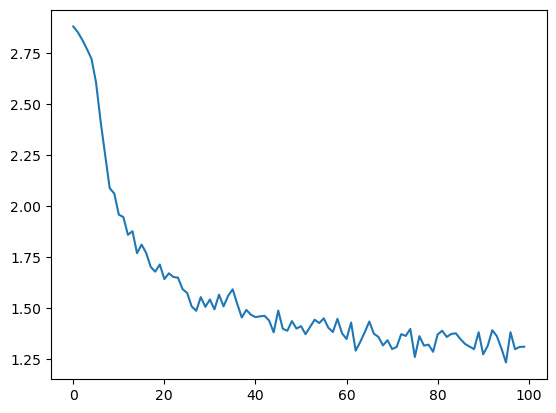

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/88/j1n2ymsd15g37s32_6_7hpgm0000gn/T/ipykernel_95211/451304968.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation = 90)
/var/folders/88/j1n2ymsd15g37s32_6_7hpgm0000gn/T/ipykernel_95211/451304968.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


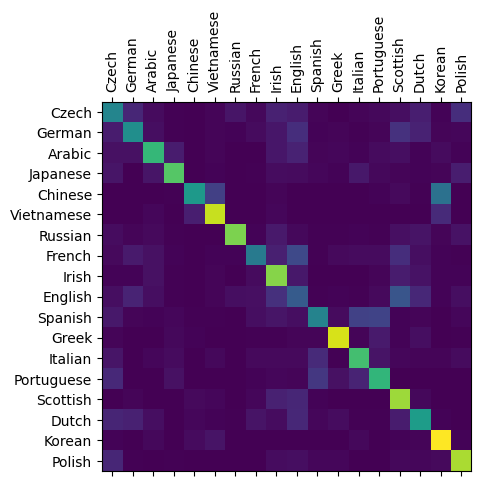

In [57]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar = (cax)


ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [58]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.85) Russian
(-1.08) Czech
(-1.84) English

> Jackson
(-0.21) Scottish
(-2.50) Korean
(-3.26) English

> Satoshi
(-0.66) Arabic
(-1.79) Italian
(-2.18) Japanese
